## production constrained model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt
import os
import networkx as nx

In [2]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
cdatasub = pd.read_csv("flow_data_with_distance.csv", index_col=0)
cdatasub.head(3)

,source,target,DestCode,Orig,OrigCode,Total,Dest,Dist,population,jobs,log_population,log_jobs,log_Dist,unconstrainedEst2
0,111,238,238,Acton Town,111,143,Alperton,4785.556297,5910,2961,8.684401,7.993282,8.473358,18
1,172,238,238,Amersham,172,83,Alperton,31267.162962,2185,2961,7.689371,7.993282,10.350324,5
2,196,238,238,Angel,196,41,Alperton,19653.911966,15124,2961,9.624038,7.993282,9.886032,24


In [4]:
path=os.getcwd()
path

os.chdir(path+'/underground/')

g_shp=nx.read_shp('underground.shp',geom_attrs=False)

df = nx.to_pandas_edgelist(g_shp)

# add station name to node
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}

nod_all = nod_st1.copy()
nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

# convert to undirected
g_shp_un = g_shp.to_undirected()

# ID assignment
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')

node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)

nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]

g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

In [5]:
# use station_1_ to model otherwise it will not be convert to dummy variables!!
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'Total ~ Orig + log_jobs + log_Dist-1' #because this is production constrained model, origin is constants.
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                33971
Model:                            GLM   Df Residuals:                    33705
Model Family:                 Poisson   Df Model:                          265
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7621e+06
Date:                Sun, 18 Apr 2021   Deviance:                   3.3704e+06
Time:                        16:08:52   Pearson chi2:                 4.93e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Orig[Acton T

In [6]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
# group by origin code, aggregate the T total flows
O_i = pd.DataFrame(cdatasub.groupby(["OrigCode"])["Total"].agg(np.sum))

O_i.rename(columns={"Total":"O_i"}, inplace = True) # notice right now, O_i is the total(aggregated) flow of origins
cdatasub = cdatasub.merge(O_i, on = "OrigCode", how = "left" )


D_j = pd.DataFrame(cdatasub.groupby(["DestCode"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "DestCode", how = "left" )
cdatasub

,source,target,DestCode,Orig,OrigCode,Total,Dest,Dist,population,jobs,log_population,log_jobs,log_Dist,unconstrainedEst2,O_i,D_j
0,111,238,238,Acton Town,111,143,Alperton,4785.556297,5910,2961,8.684401,7.993282,8.473358,18,5910,2961
1,172,238,238,Amersham,172,83,Alperton,31267.162962,2185,2961,7.689371,7.993282,10.350324,5,2185,2961
2,196,238,238,Angel,196,41,Alperton,19653.911966,15124,2961,9.624038,7.993282,9.886032,24,15124,2961
3,244,238,238,Arsenal,244,14,Alperton,21822.468189,3320,2961,8.107720,7.993282,9.990695,7,3320,2961
4,25,238,238,Bank,25,44,Alperton,18991.049336,79588,2961,11.284619,7.993282,9.851723,88,79588,2961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33966,72,129,129,South Woodford,72,20,Upminster Bridge,24206.073670,5772,1321,8.660774,7.186144,10.094359,6,5772,1321
33967,135,129,129,Upminster,135,214,Upminster Bridge,1161.583961,3746,1321,8.228444,7.186144,7.057540,11,3746,1321
33968,119,129,129,Upton Park,119,18,Upminster Bridge,14272.568062,10318,1321,9.241645,7.186144,9.566095,11,10318,1321
33969,109,129,129,West Ham,109,8,Upminster Bridge,16391.363195,14672,1321,9.593696,7.186144,9.704510,14,14672,1321


In [7]:
#pulling out the paramater values in the summary table
coefs = pd.DataFrame(prodSim.params) #prodsim is the fitted model, where we pull out parameters
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(Orig)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="Orig", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub

/Users/zhangjiawei/opt/anaconda3/envs/urbsim/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,source,target,DestCode,Orig,OrigCode,Total,Dest,Dist,population,jobs,log_population,log_jobs,log_Dist,unconstrainedEst2,O_i,D_j,alpha_i
0,111,238,238,Acton Town,111,143,Alperton,4785.556297,5910,2961,8.684401,7.993282,8.473358,18,5910,2961,1.522589
1,172,238,238,Amersham,172,83,Alperton,31267.162962,2185,2961,7.689371,7.993282,10.350324,5,2185,2961,1.316839
2,196,238,238,Angel,196,41,Alperton,19653.911966,15124,2961,9.624038,7.993282,9.886032,24,15124,2961,1.826781
3,244,238,238,Arsenal,244,14,Alperton,21822.468189,3320,2961,8.107720,7.993282,9.990695,7,3320,2961,0.767704
4,25,238,238,Bank,25,44,Alperton,18991.049336,79588,2961,11.284619,7.993282,9.851723,88,79588,2961,3.378537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33966,72,129,129,South Woodford,72,20,Upminster Bridge,24206.073670,5772,1321,8.660774,7.186144,10.094359,6,5772,1321,1.602858
33967,135,129,129,Upminster,135,214,Upminster Bridge,1161.583961,3746,1321,8.228444,7.186144,7.057540,11,3746,1321,1.848581
33968,119,129,129,Upton Park,119,18,Upminster Bridge,14272.568062,10318,1321,9.241645,7.186144,9.566095,11,10318,1321,2.005422
33969,109,129,129,West Ham,109,8,Upminster Bridge,16391.363195,14672,1321,9.593696,7.186144,9.704510,14,14672,1321,2.372160


In [8]:
coefs

,coef,alpha_i
0,Acton Town,1.522589
1,Aldgate,1.606787
2,Aldgate East,1.717115
3,Alperton,1.408234
4,Amersham,1.316839
...,...,...
261,Wood Green,2.200868
262,Woodford,1.840297
263,Woodside Park,1.505215
264,log_jobs,0.705686


In [9]:
alpha_i = prodSim.params[:-2]
gamma = prodSim.params[-2]
beta = prodSim.params[-1]

In [10]:
beta

-0.47323083738827665

In [11]:
cdatasub["prodsimest1"] = np.exp(cdatasub["alpha_i"]+gamma*cdatasub["log_jobs"] + beta*cdatasub["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdatasub.head(10)

,source,target,DestCode,Orig,OrigCode,Total,Dest,Dist,population,jobs,log_population,log_jobs,log_Dist,unconstrainedEst2,O_i,D_j,alpha_i,prodsimest1
0,111,238,238,Acton Town,111,143,Alperton,4785.556297,5910,2961,8.684401,7.993282,8.473358,18,5910,2961,1.522589,23.417399
1,172,238,238,Amersham,172,83,Alperton,31267.162962,2185,2961,7.689371,7.993282,10.350324,5,2185,2961,1.316839,7.841979
2,196,238,238,Angel,196,41,Alperton,19653.911966,15124,2961,9.624038,7.993282,9.886032,24,15124,2961,1.826781,16.267196
3,244,238,238,Arsenal,244,14,Alperton,21822.468189,3320,2961,8.107720,7.993282,9.990695,7,3320,2961,0.767704,5.368470
4,25,238,238,Bank,25,44,Alperton,18991.049336,79588,2961,11.284619,7.993282,9.851723,88,79588,2961,3.378537,78.033767
5,100,238,238,Barons Court,100,6,Alperton,9659.783792,7687,2961,8.947286,7.993282,9.175727,18,7687,2961,1.557055,17.384218
6,81,238,238,Blackfriars,81,46,Alperton,18144.539344,16256,2961,9.696217,7.993282,9.806125,26,16256,2961,2.030457,20.710493
7,269,238,238,Blackhorse Road,269,15,Alperton,27917.993308,10267,2961,9.236690,7.993282,10.237027,16,10267,2961,2.095103,18.017986
8,3,238,238,Charing Cross,3,19,Alperton,16492.309266,15330,2961,9.637567,7.993282,9.710649,26,15330,2961,1.739672,16.200423
9,110,238,238,Chiswick Park,110,37,Alperton,6035.306895,2265,2961,7.725330,7.993282,8.705382,8,2265,2961,0.627454,8.572361


In [12]:
#first round the estimates
cdatasub["prodsimest1"] = round(cdatasub["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
# cdatasubmat3 = cdatasub.pivot_table(values ="prodsimest1", index="Orig", columns = "Dest",
#                             aggfunc=np.sum, margins=True)
# cdatasubmat3

In [13]:
#the first estimate Ai

#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["jobs"]**gamma
dist_beta = cdatasub["Dist"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCode"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i1"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCode", right_index=True, how="left")

# now we have got A gamma alpha and beta, rewrite the equation and estimate 

#to check everything works, recreate the original estimates
cdatasub["prodsimest2"] = cdatasub["A_i1"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest2"] = round(cdatasub["prodsimest2"])
#check
cdatasub

,source,target,DestCode,Orig,OrigCode,Total,Dest,Dist,population,jobs,...,log_jobs,log_Dist,unconstrainedEst2,O_i,D_j,alpha_i,prodsimest1,Ai1,A_i1,prodsimest2
0,111,238,238,Acton Town,111,143,Alperton,4785.556297,5910,2961,...,7.993282,8.473358,18,5910,2961,1.522589,23.0,5.108420,0.000776,23.0
1,172,238,238,Amersham,172,83,Alperton,31267.162962,2185,2961,...,7.993282,10.350324,5,2185,2961,1.316839,8.0,2.101501,0.001708,8.0
2,196,238,238,Angel,196,41,Alperton,19653.911966,15124,2961,...,7.993282,9.886032,24,15124,2961,1.826781,16.0,2.617892,0.000411,16.0
3,244,238,238,Arsenal,244,14,Alperton,21822.468189,3320,2961,...,7.993282,9.990695,7,3320,2961,0.767704,5.0,2.491386,0.000649,5.0
4,25,238,238,Bank,25,44,Alperton,18991.049336,79588,2961,...,7.993282,9.851723,88,79588,2961,3.378537,78.0,2.660742,0.000368,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33966,72,129,129,South Woodford,72,20,Upminster Bridge,24206.073670,5772,1321,...,7.186144,10.094359,6,5772,1321,1.602858,7.0,1.342048,0.000861,7.0
33967,135,129,129,Upminster,135,214,Upminster Bridge,1161.583961,3746,1321,...,7.186144,7.057540,11,3746,1321,1.848581,36.0,5.648066,0.001695,36.0
33968,119,129,129,Upton Park,119,18,Upminster Bridge,14272.568062,10318,1321,...,7.186144,9.566095,11,10318,1321,2.005422,13.0,1.723208,0.000720,13.0
33969,109,129,129,West Ham,109,8,Upminster Bridge,16391.363195,14672,1321,...,7.186144,9.704510,14,14672,1321,2.372160,17.0,1.613951,0.000731,17.0


In [14]:
cdatasubmat1 = cdatasub.pivot_table(values ="prodsimest1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

Dest,Acton Town,Aldgate,Aldgate East,Alperton,Amersham,Angel,Archway,Arnos Grove,Arsenal,Baker Street,...,White City,Whitechapel,Willesden Green,Willesden Junction,Wimbledon,Wimbledon Park,Wood Green,Woodford,Woodside Park,All
Orig,,,,,,,,,,,,,,,,,,,,,
Acton Town,NaN,NaN,NaN,23.0,5.0,48.0,24.0,NaN,9.0,74.0,...,NaN,54.0,22.0,NaN,37.0,10.0,26.0,NaN,NaN,5906.0
Aldgate,21.0,NaN,NaN,NaN,5.0,106.0,36.0,17.0,15.0,104.0,...,NaN,NaN,28.0,NaN,37.0,NaN,37.0,22.0,14.0,9982.0
Aldgate East,24.0,NaN,NaN,NaN,NaN,117.0,40.0,19.0,NaN,115.0,...,44.0,258.0,NaN,NaN,41.0,NaN,NaN,25.0,NaN,11552.0
Alperton,31.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,7.0,56.0,...,NaN,NaN,NaN,NaN,29.0,NaN,21.0,NaN,NaN,3080.0
Amersham,NaN,18.0,NaN,8.0,NaN,24.0,NaN,NaN,NaN,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wimbledon Park,NaN,NaN,22.0,7.0,NaN,26.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,2502.0
Wood Green,NaN,80.0,91.0,20.0,NaN,118.0,NaN,69.0,33.0,149.0,...,61.0,NaN,44.0,NaN,58.0,NaN,NaN,NaN,NaN,12712.0
Woodford,NaN,51.0,60.0,NaN,NaN,62.0,29.0,NaN,NaN,77.0,...,35.0,84.0,NaN,NaN,35.0,NaN,NaN,NaN,NaN,7002.0


In [15]:
cdatasubmat = pd.pivot_table(cdatasub, values ="Total", index="OrigCode", columns = "DestCode",
                            aggfunc=np.sum, margins=True)
cdatasubmat

DestCode,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,All
OrigCode,,,,,,,,,,,,,,,,,,,,,
0,NaN,35.0,NaN,290.0,73.0,744.0,6.0,177.0,63.0,12.0,...,NaN,NaN,22.0,168.0,33.0,156.0,71.0,0.0,202.0,24812
1,137.0,NaN,31.0,509.0,802.0,314.0,0.0,662.0,142.0,48.0,...,NaN,19.0,6.0,24.0,270.0,12.0,93.0,12.0,77.0,12576
2,0.0,43.0,NaN,218.0,56.0,131.0,3.0,302.0,123.0,28.0,...,NaN,NaN,NaN,43.0,62.0,0.0,NaN,NaN,54.0,3128
3,255.0,623.0,312.0,NaN,14.0,300.0,263.0,1245.0,146.0,76.0,...,8.0,100.0,64.0,170.0,83.0,285.0,329.0,0.0,NaN,15330
4,0.0,283.0,52.0,92.0,NaN,109.0,68.0,179.0,84.0,29.0,...,NaN,17.0,173.0,5.0,139.0,2.0,3.0,73.0,1.0,15667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,117.0,5.0,6.0,414.0,74.0,249.0,0.0,477.0,115.0,79.0,...,NaN,225.0,781.0,1211.0,922.0,NaN,2033.0,422.0,1418.0,39129
274,269.0,47.0,3.0,196.0,122.0,145.0,NaN,168.0,267.0,120.0,...,NaN,181.0,70.0,512.0,613.0,2143.0,NaN,257.0,960.0,27457
275,12.0,119.0,11.0,32.0,52.0,140.0,78.0,128.0,0.0,10.0,...,NaN,67.0,164.0,167.0,112.0,220.0,298.0,NaN,223.0,10695


In [16]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest1"])

0.37467065549280987

In [17]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest1"])

205.912

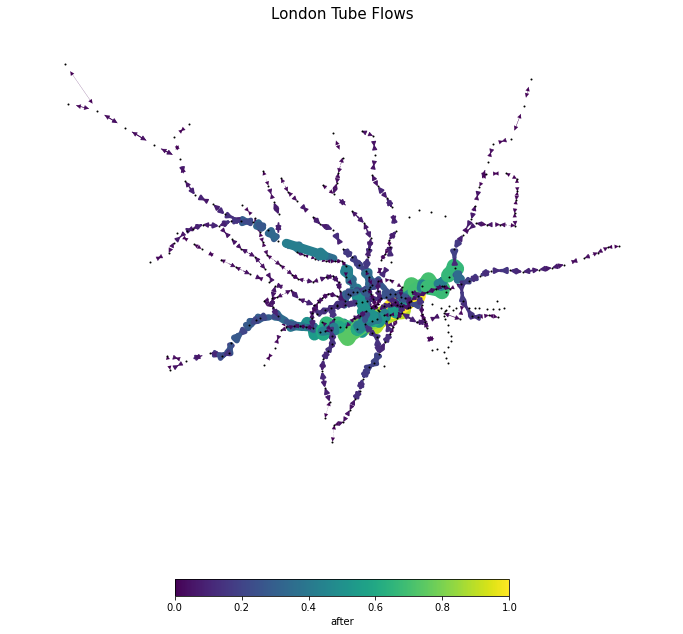

In [23]:
# pivot table
cdatasubmat = cdatasub.pivot_table(values ="prodsimest1", index="OrigCode", columns = "DestCode",
                            aggfunc=np.sum, margins=True)
cdatasubmat.drop('All',axis='columns', inplace=True)
cdatasubmat.drop('All',axis='index', inplace=True)
#cdatasubmat

# from pivot to matrix
index = cdatasubmat.index.union(cdatasubmat.columns)
cdatasubmat = cdatasubmat.reindex(index=index, columns=index)
cdatasubmat=cdatasubmat.to_numpy(na_value=0)
# cdatasubmat

#put weight into shorest path
G=nx.from_numpy_matrix(cdatasubmat, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in G.edges(data='weight'): #e1 is origin, e2 is destination, c is weight on the edge
    path = nx.dijkstra_path(g_shp_un,e1,e2)  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path


G=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]

#node
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(G,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(G,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(G.nodes[e1]['station'],G.nodes[e2]['station']) for e1,e2 in G.edges()}

nx.set_edge_attributes(G,edges_names,'station_names')

#list(G.edges(data=True))[0:10]

# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in G.edges(data='weight')]

weights_color=[(w/2000) for e1,e2,w in G.edges(data='weight')]
weights_size=[(w/20000) for e1,e2,w in G.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color=weights_color, width=weights_size)

nod= nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(nod,label="after",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

In [ ]:
# another plot
# libraries
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

# data set
nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')

# chord diagram
chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))

## jobs increase senario 

use the beta from the first model

In [25]:
# the Canary Wharf station
station=cdatasub[cdatasub.Dest.str.contains('Canary Wharf')]
code=station.DestCode.unique()
code[0]

156

In [26]:
def new_sal(row):
    if row["DestCode"] == code[0]:
        val = row["jobs"]/2
    else:
        val = row["jobs"]
    return val
        
cdatasub["jobScenario"] = cdatasub.apply(new_sal, axis =1)
#cdatasub.head(10)

In [27]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["jobScenario"]**gamma
dist_beta = cdatasub["Dist"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai2"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCode"])["Ai2"].agg(np.sum))
#now divide into 1
A_i["Ai2"] = 1/A_i["Ai2"]
A_i.rename(columns={"Ai2":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCode", right_index=True, how="left")
#cdatasub

#to check everything works, recreate the original estimates
cdatasub["prodsimest3"] = cdatasub["A_i2"]*cdatasub["O_i"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest3"] = round(cdatasub["prodsimest3"])
cdatasub

,source,target,DestCode,Orig,OrigCode,Total,Dest,Dist,population,jobs,...,D_j,alpha_i,prodsimest1,Ai1,A_i1,prodsimest2,jobScenario,Ai2,A_i2,prodsimest3
0,111,238,238,Acton Town,111,143,Alperton,4785.556297,5910,2961,...,2961,1.522589,23.0,5.108420,0.000776,23.0,2961.0,5.108420,0.000781,24.0
1,172,238,238,Amersham,172,83,Alperton,31267.162962,2185,2961,...,2961,1.316839,8.0,2.101501,0.001708,8.0,2961.0,2.101501,0.001726,8.0
2,196,238,238,Angel,196,41,Alperton,19653.911966,15124,2961,...,2961,1.826781,16.0,2.617892,0.000411,16.0,2961.0,2.617892,0.000413,16.0
3,244,238,238,Arsenal,244,14,Alperton,21822.468189,3320,2961,...,2961,0.767704,5.0,2.491386,0.000649,5.0,2961.0,2.491386,0.000654,5.0
4,25,238,238,Bank,25,44,Alperton,18991.049336,79588,2961,...,2961,3.378537,78.0,2.660742,0.000368,78.0,2961.0,2.660742,0.000371,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33966,72,129,129,South Woodford,72,20,Upminster Bridge,24206.073670,5772,1321,...,1321,1.602858,7.0,1.342048,0.000861,7.0,1321.0,1.342048,0.000870,7.0
33967,135,129,129,Upminster,135,214,Upminster Bridge,1161.583961,3746,1321,...,1321,1.848581,36.0,5.648066,0.001695,36.0,1321.0,5.648066,0.001721,36.0
33968,119,129,129,Upton Park,119,18,Upminster Bridge,14272.568062,10318,1321,...,1321,2.005422,13.0,1.723208,0.000720,13.0,1321.0,1.723208,0.000728,13.0
33969,109,129,129,West Ham,109,8,Upminster Bridge,16391.363195,14672,1321,...,1321,2.372160,17.0,1.613951,0.000731,17.0,1321.0,1.613951,0.000741,18.0


In [28]:
cdatasubmat3 = cdatasub.pivot_table(values ="prodsimest3", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

Dest,Acton Town,Aldgate,Aldgate East,Alperton,Amersham,Angel,Archway,Arnos Grove,Arsenal,Baker Street,...,White City,Whitechapel,Willesden Green,Willesden Junction,Wimbledon,Wimbledon Park,Wood Green,Woodford,Woodside Park,All
Orig,,,,,,,,,,,,,,,,,,,,,
Acton Town,NaN,NaN,NaN,24.0,5.0,49.0,25.0,NaN,9.0,74.0,...,NaN,54.0,22.0,NaN,38.0,10.0,26.0,NaN,NaN,5909.0
Aldgate,21.0,NaN,NaN,NaN,5.0,106.0,36.0,17.0,15.0,104.0,...,NaN,NaN,28.0,NaN,37.0,NaN,37.0,22.0,14.0,9982.0
Aldgate East,24.0,NaN,NaN,NaN,NaN,117.0,40.0,19.0,NaN,115.0,...,44.0,258.0,NaN,NaN,41.0,NaN,NaN,25.0,NaN,11552.0
Alperton,31.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,7.0,56.0,...,NaN,NaN,NaN,NaN,29.0,NaN,21.0,NaN,NaN,3080.0
Amersham,NaN,18.0,NaN,8.0,NaN,25.0,NaN,NaN,NaN,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wimbledon Park,NaN,NaN,22.0,7.0,NaN,26.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,2501.0
Wood Green,NaN,80.0,92.0,21.0,NaN,119.0,NaN,70.0,33.0,150.0,...,61.0,NaN,45.0,NaN,58.0,NaN,NaN,NaN,NaN,12720.0
Woodford,NaN,51.0,61.0,NaN,NaN,63.0,30.0,NaN,NaN,78.0,...,35.0,84.0,NaN,NaN,36.0,NaN,NaN,NaN,NaN,6999.0


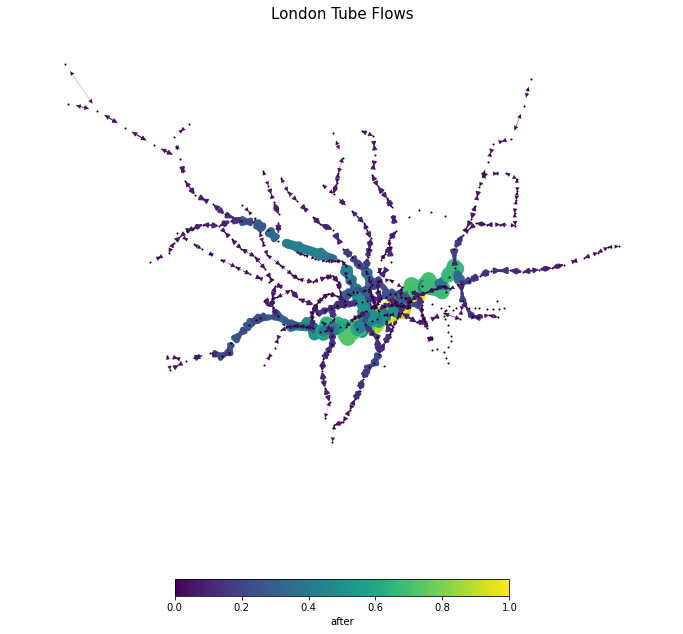

In [29]:
# pivot table
cdatasubmat = cdatasub.pivot_table(values ="prodsimest3", index="OrigCode", columns = "DestCode",
                            aggfunc=np.sum, margins=True)
cdatasubmat.drop('All',axis='columns', inplace=True)
cdatasubmat.drop('All',axis='index', inplace=True)
#cdatasubmat

# from pivot to matrix
index = cdatasubmat.index.union(cdatasubmat.columns)
cdatasubmat = cdatasubmat.reindex(index=index, columns=index)
cdatasubmat=cdatasubmat.to_numpy(na_value=0)
# cdatasubmat

#put weight into shorest path
G=nx.from_numpy_matrix(cdatasubmat, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in G.edges(data='weight'): #e1 is origin, e2 is destination, c is weight on the edge
    path = nx.dijkstra_path(g_shp_un,e1,e2)  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path


G=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]

#node
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(G,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(G,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(G.nodes[e1]['station'],G.nodes[e2]['station']) for e1,e2 in G.edges()}

nx.set_edge_attributes(G,edges_names,'station_names')

#list(G.edges(data=True))[0:10]

# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in G.edges(data='weight')]

weights_color=[(w/2000) for e1,e2,w in G.edges(data='weight')]
weights_size=[(w/20000) for e1,e2,w in G.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color=weights_color, width=weights_size)

nod= nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(nod,label="after",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

## two values in cost function

In [ ]:
beta= -0.5
#the first estimate Ai

#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["jobs"]**gamma
dist_beta = cdatasub["Dist"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai3"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCode"])["Ai3"].agg(np.sum))
#now divide into 1
A_i["Ai3"] = 1/A_i["Ai3"]
A_i.rename(columns={"Ai3":"A_i3"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCode", right_index=True, how="left")

# now we have got A gamma alpha and beta, rewrite the equation and estimate 

#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i3"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])
#check
cdatasub

In [ ]:
cdatasubmat4 = cdatasub.pivot_table(values ="prodsimest4", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

In [ ]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest4"])

In [ ]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest4"])

In [ ]:
# pivot table
cdatasubmat = cdatasub.pivot_table(values ="prodsimest4", index="OrigCode", columns = "DestCode",
                            aggfunc=np.sum, margins=True)
cdatasubmat.drop('All',axis='columns', inplace=True)
cdatasubmat.drop('All',axis='index', inplace=True)
#cdatasubmat

# from pivot to matrix
index = cdatasubmat.index.union(cdatasubmat.columns)
cdatasubmat = cdatasubmat.reindex(index=index, columns=index)
cdatasubmat=cdatasubmat.to_numpy(na_value=0)
# cdatasubmat

#put weight into shorest path
G=nx.from_numpy_matrix(cdatasubmat, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in G.edges(data='weight'): #e1 is origin, e2 is destination, c is weight on the edge
    path = nx.dijkstra_path(g_shp_un,e1,e2)  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path


G=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]

#node
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(G,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(G,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(G.nodes[e1]['station'],G.nodes[e2]['station']) for e1,e2 in G.edges()}

nx.set_edge_attributes(G,edges_names,'station_names')

#list(G.edges(data=True))[0:10]

# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in G.edges(data='weight')]

weights_color=[(w/2000) for e1,e2,w in G.edges(data='weight')]
weights_size=[(w/20000) for e1,e2,w in G.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color=weights_color, width=weights_size)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(nod,label="after",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

## another parameter

In [ ]:
beta= -1.5
#the first estimate Ai

#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["jobs"]**gamma
dist_beta = cdatasub["Dist"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai4"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCode"])["Ai4"].agg(np.sum))
#now divide into 1
A_i["Ai4"] = 1/A_i["Ai4"]
A_i.rename(columns={"Ai4":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCode", right_index=True, how="left")

# now we have got A gamma alpha and beta, rewrite the equation and estimate 

#to check everything works, recreate the original estimates
cdatasub["prodsimest5"] = cdatasub["A_i4"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest5"] = round(cdatasub["prodsimest5"])
#check
cdatasub

In [ ]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest5"])

In [ ]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest5"])

In [ ]:
# pivot table
cdatasubmat5 = cdatasub.pivot_table(values ="prodsimest5", index="OrigCode", columns = "DestCode",
                            aggfunc=np.sum, margins=True)
cdatasubmat5.drop('All',axis='columns', inplace=True)
cdatasubmat5.drop('All',axis='index', inplace=True)
#cdatasubmat5

# from pivot to matrix
index = cdatasubmat5.index.union(cdatasubmat5.columns)
cdatasubmat5 = cdatasubmat5.reindex(index=index, columns=index)
cdatasubmat5=cdatasubmat5.to_numpy(na_value=0)
# cdatasubmat5

#put weight into shorest path
G=nx.from_numpy_matrix(cdatasubmat5, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in G.edges(data='weight'): #e1 is origin, e2 is destination, c is weight on the edge
    path = nx.dijkstra_path(g_shp_un,e1,e2)  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path


G=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)
#list(G.edges(data=True))[0:10]

#node
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(G,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(G,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(G.nodes[e1]['station'],G.nodes[e2]['station']) for e1,e2 in G.edges()}

nx.set_edge_attributes(G,edges_names,'station_names')

#list(G.edges(data=True))[0:10]

# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in G.edges(data='weight')]

weights_color=[(w/2000) for e1,e2,w in G.edges(data='weight')]
weights_size=[(w/20000) for e1,e2,w in G.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color=weights_color, width=weights_size)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(nod,label="after",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

In [ ]:
# Lets set color and width of edges according to betweenness values
betweenness_e_values=cdatasub["prodsimest5"]

bet_e_color=[(cdatasub["prodsimest5"]/max(betweenness_e_values))]
bet_e_width=[(cdatasub["prodsimest5"]/max(betweenness_e_values)*10) ]



# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(g_shp_un, pos,edge_color=bet_e_color, width=bet_e_width)

nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube edge betweenness centrality",fontsize=15)
plt.show()

##### cost function

In [ ]:
# use station_1_ to model otherwise it will not be convert to dummy variables!!
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'Total ~ Orig + log_jobs + Dist-1' #because this is production constrained model, origin is constants.
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

In [ ]:
# #pulling out the paramater values in the summary table
# coefs = pd.DataFrame(prodSim.params) #prodsim is the fitted model, where we pull out parameters
# coefs.reset_index(inplace=True)
# coefs.rename(columns = {0:"alpha_i2", "index":"coef"}, inplace = True)
# to_repl = ["(Orig)", "\[", "\]"]
# for x in to_repl:
#     coefs["coef"] = coefs["coef"].str.replace(x, "")

# #then once you have done this you can join them back into the dataframes
# cdatasub = cdatasub.merge(coefs, left_on="Orig", right_on="coef", how = "left")
# cdatasub.drop(columns = ["coef"], inplace = True)
# #check this has worked
# cdatasub

In [ ]:
# alpha_i = prodSim.params[:-2]
# gamma = prodSim.params[-2]
# beta = prodSim.params[-1]

# cdatasub["doubsimfitted2"] = np.exp(cdatasub["alpha_i"]+gamma*cdatasub["log_jobs"] + beta*cdatasub["Dist"])
# #or you could do it the easy way like we did last week with the fitted column (See previous practical)
# cdatasub["doubsimfitted2"] = round(cdatasub["doubsimfitted2"],0)

In [ ]:
cdatasub["doubsimfitted1"] = np.round(prodSim.predict(),0)

In [ ]:
cdatasub

In [ ]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted1"])

In [ ]:
CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted1"])

In [ ]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["jobs"]**gamma
dist_beta = cdatasub["Dist"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai3"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCode"])["Ai3"].agg(np.sum))
#now divide into 1
A_i["Ai3"] = 1/A_i["Ai3"]
A_i.rename(columns={"Ai3":"A_i3"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCode", right_index=True, how="left")
#cdatasub

In [ ]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i3"]*cdatasub["O_i"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])
cdatasub